In [0]:
sandbox = 
PATH_DATA = '/data/sandboxes/'+sandbox+'/data/data/'

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.2.1-bin-hadoop2.7"

In [0]:
import findspark
findspark.init()
from pyspark.sql import SparkSession

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
spark = SparkSession.builder.master("local[*]").getOrCreate()



# Workshop de Spark

Cargamos un dataset con información de una campaña de marketing portuguesa para la venta de un préstamo bancario. El objetivo es, una vez limpiado el dataset, estudiarlo para extraer el máximo número de insights de los datos.

In [0]:
DATAPATH = os.path.join('content', 'drive', 'My Drive','Data') 
filepath = os.path.join(DATAPATH, 'bank-full.csv')
print(filepath)

content/drive/My Drive/Data/bank-full.csv



##Importacion de librerias

In [0]:
from pyspark.sql import functions as F
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.stat import Statistics
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns



## Lectura de datos

In [0]:
df_bank = spark.read.csv('file:///' + filepath, sep=';', header=True, inferSchema=True)
df_bank.show()

+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+---+--------------+----------+
|age|         job| marital|education|default|balance|housing|loan|contact|day|month|year|duration|campaign|pdays|previous|poutcome|  y|picked_up_call|extra_info|
+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+---+--------------+----------+
| 58|  management| married| tertiary|     no|   2143|    yes|  no|unknown|  5|  may|2008|     261|       1|   -1|       0| unknown| no|             1|         1|
| 44|  technician|  single|secondary|     no|     29|    yes|  no|unknown|  5|  may|2008|     151|       1|   -1|       0| unknown| no|             1|         1|
| 33|entrepreneur| married|secondary|     no|      2|    yes| yes|unknown|  5|  may|2008|      76|       1|   -1|       0| unknown| no|             1|         1|
| 47| blue-collar| married| 

## Analisis del dataframe:
### 1 Dimensiones
### 2 Columnas: comprobar que los nombres cumplen las normas y analizar y separar por los tipos de las mismas

### 1 Dimensiones del dataframe
Generamos una función para llamarla siempre que sea necesario estudiar las dimensiones del df

In [0]:
def shape(df):
    nrows=df.count()
    ncols=len(df.columns)
    return [nrows, ncols]

In [0]:
nrows= shape(df_bank)[0]
ncols= shape(df_bank)[1]
print('El dataframe tiene {} filas y {} columnas'.format(nrows,ncols))

El dataframe tiene 45211 filas y 20 columnas


. 

### 2. COLUMNAS  

    

 #### 2.a) Comprobar que los nombres de todas las columnas cumplen las buenas prácticas y si no, modificar.

Conclusion: Todos los nombres de columnas siguen las buenas prácticas

In [0]:
df_bank.dtypes

[('age', 'int'),
 ('job', 'string'),
 ('marital', 'string'),
 ('education', 'string'),
 ('default', 'string'),
 ('balance', 'int'),
 ('housing', 'string'),
 ('loan', 'string'),
 ('contact', 'string'),
 ('day', 'int'),
 ('month', 'string'),
 ('year', 'int'),
 ('duration', 'int'),
 ('campaign', 'int'),
 ('pdays', 'int'),
 ('previous', 'int'),
 ('poutcome', 'string'),
 ('y', 'string'),
 ('picked_up_call', 'int'),
 ('extra_info', 'int')]

#### 2.b) Crear las listas de columnas numéricas y categóricas por separado para ser usadas posteriormente

In [0]:
col_nv = ['day','month','year']
quantitative_vars = [c for c,t in df_bank.dtypes if (t in ['int', 'double']) & ~(c in col_nv)]
qualitative_vars = [c for c,t in df_bank.dtypes if (t in ['boolean', 'string']) & ~(c in col_nv)]

print(quantitative_vars,qualitative_vars)

['age', 'balance', 'duration', 'campaign', 'pdays', 'previous', 'picked_up_call', 'extra_info'] ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome', 'y']


## ANALISIS DESCRIPTVO DE LOS DATOS:
###1) Estadisticas descriptivas de las columnas cuantitativas
###2) Análisis de nulos
###3) Analizar las diferentes categorias de las variables: alta concentración en alguna, valores raros, etc

### 1) Obtenemos las estadisticas basicas de las columnas cuantitativas

In [0]:
df_bank.select([F.round(F.avg(col),2).alias('avg_'+col) for col in quantitative_vars]).show()
df_bank.select([F.round(F.max(col),2).alias('max_'+col) for col in quantitative_vars]).show()
df_bank.select([F.round(F.min(col),2).alias('min_'+col) for col in quantitative_vars]).show()
df_bank.select([F.round(F.stddev(col),2).alias('std_'+col) for col in quantitative_vars]).show()


+-------+-----------+------------+------------+---------+------------+------------------+--------------+
|avg_age|avg_balance|avg_duration|avg_campaign|avg_pdays|avg_previous|avg_picked_up_call|avg_extra_info|
+-------+-----------+------------+------------+---------+------------+------------------+--------------+
|  40.94|    1362.27|      258.16|        2.76|     40.2|        0.58|               1.0|          1.64|
+-------+-----------+------------+------------+---------+------------+------------------+--------------+

+-------+-----------+------------+------------+---------+------------+------------------+--------------+
|max_age|max_balance|max_duration|max_campaign|max_pdays|max_previous|max_picked_up_call|max_extra_info|
+-------+-----------+------------+------------+---------+------------+------------------+--------------+
|     95|     102127|        4918|          63|      871|         275|                 1|            11|
+-------+-----------+------------+------------+-------

### 2 Analisis de nulos


Analizamos el procentaje de nulos de todas las columnas

In [0]:
#Obtenemos el % de missing para cada una de las variables
n_rows_bank = df_bank.count()
lista_perc_missing=[]
for col in df_bank.columns:
  n_missing = df_bank.filter(F.col(col).isNull()).count()
  perc_missing = 100 * n_missing / n_rows_bank
  lista_perc_missing.append([col, round(perc_missing, 2)])
   
  print(col, round(perc_missing, 2))

Creamos la lista de variables a eliminar si el porcentaje de missing es superior al 80%

In [0]:
#Columnas que eliminaremos por alto porcentaje en nulos
drop_col= [x for x,y in lista_perc_missing if y>80]
drop_col

['extra_info']

### 3) Análisis de las variables por categorias

Para todas las columnas agrupamos contando los registros por grupo dentro de cada columna y ordenamos de mayor a menor para analizar alta concentracion en alguna que nos lleve a eliminar la variable por no aportar información discriminante (pedimos solo 10 categorias)

In [0]:
for x in df_bank.columns:
  df_bank.groupBy(x).count().orderBy(F.col('count').desc()).show()


+---+-----+
|age|count|
+---+-----+
| 32| 2085|
| 31| 1996|
| 33| 1972|
| 34| 1930|
| 35| 1894|
| 36| 1806|
| 30| 1757|
| 37| 1696|
| 39| 1487|
| 38| 1466|
| 40| 1355|
| 41| 1291|
| 42| 1242|
| 45| 1216|
| 29| 1185|
| 46| 1175|
| 43| 1161|
| 44| 1136|
| 47| 1088|
| 28| 1038|
+---+-----+
only showing top 20 rows

+-------------+-----+
|          job|count|
+-------------+-----+
|  blue-collar| 9732|
|   management| 9458|
|   technician| 7597|
|       admin.| 5171|
|     services| 4154|
|      retired| 2264|
|self-employed| 1579|
| entrepreneur| 1487|
|   unemployed| 1303|
|    housemaid| 1240|
|      student|  938|
|      unknown|  288|
+-------------+-----+

+--------+-----+
| marital|count|
+--------+-----+
| married|27214|
|  single|12790|
|divorced| 5207|
+--------+-----+

+---------+-----+
|education|count|
+---------+-----+
|secondary|23202|
| tertiary|13301|
|  primary| 6851|
|  unknown| 1857|
+---------+-----+

+-------+-----+
|default|count|
+-------+-----+
|     no|44396|
|   

In [0]:
for x in df_bank.columns:
  
  i = df_bank.filter(F.col(x)=='unknown').count()
  
  if i>0:
    df_bank = df_bank.withColumn(x+ '_null', F.when(F.regexp_replace(F.col(x), ' ', '')=='unknown', None).otherwise(F.col(x))).drop(x).withColumnRenamed(x+ '_null',x)
                                   

In [0]:
df_bank.show()

+---+--------+-------+-------+-------+----+---+-----+----+--------+--------+-----+--------+---+--------------+----------+------------+---------+-------+--------+
|age| marital|default|balance|housing|loan|day|month|year|duration|campaign|pdays|previous|  y|picked_up_call|extra_info|         job|education|contact|poutcome|
+---+--------+-------+-------+-------+----+---+-----+----+--------+--------+-----+--------+---+--------------+----------+------------+---------+-------+--------+
| 58| married|     no|   2143|    yes|  no|  5|  may|2008|     261|       1|   -1|       0| no|             1|         1|  management| tertiary|   null|    null|
| 44|  single|     no|     29|    yes|  no|  5|  may|2008|     151|       1|   -1|       0| no|             1|         1|  technician|secondary|   null|    null|
| 33| married|     no|      2|    yes| yes|  5|  may|2008|      76|       1|   -1|       0| no|             1|         1|entrepreneur|secondary|   null|    null|
| 47| married|     no|   150

In [0]:
n_rows_bank = df_bank.count()
lista_perc_missing=[]
for col in df_bank.columns:
  n_missing = df_bank.filter(F.col(col).isNull()).count()
  perc_missing = 100 * n_missing / n_rows_bank
  lista_perc_missing.append([col, round(perc_missing, 2)])
   
  print(col, round(perc_missing, 2))

age 0.0
marital 0.0
default 0.0
balance 0.0
housing 0.0
loan 0.0
day 0.0
month 0.0
year 0.0
duration 0.0
campaign 0.0
pdays 0.0
previous 0.0
y 0.0
picked_up_call 0.0
extra_info 99.83
job 0.64
education 4.11
contact 28.8
poutcome 81.75


In [0]:
drop_col= [x for x,y in lista_perc_missing if (y>80)]
drop_col

['extra_info', 'poutcome']

2.5 Como conclusion al punto 2, eliminamos la variable extra_info por missings tanto del df como de la lista de columnas numericas

In [0]:
df_bank = df_bank.drop(*drop_col)

In [0]:
#comprobamos que las dimensiones del df son las esperadas
nrows= shape(df_bank)[0]
ncols= shape(df_bank)[1]
print('El dataframe tiene {} filas y {} columnas'.format(nrows,ncols))

El dataframe tiene 45211 filas y 18 columnas


In [0]:
qualitative_vars_limp = [x for x in qualitative_vars if x not in drop_col] 
qualitative_vars_limp

['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'y']

In [0]:
quantitative_vars_limp = [x for x in quantitative_vars if x not in drop_col] 
quantitative_vars_limp

['age',
 'balance',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'picked_up_call']

In [0]:
for x in df_bank.columns:
  
  y,z = df_bank.groupBy(x).count().orderBy(F.col('count').desc()).first()

  df_bank = df_bank.fillna(y,subset=[x])
                                 
  print ('el valor mas frequente de {} es {}'.format(x,y))

el valor mas frequente de age es 32
el valor mas frequente de marital es married
el valor mas frequente de default es no
el valor mas frequente de balance es 0
el valor mas frequente de housing es yes
el valor mas frequente de loan es no
el valor mas frequente de day es 20
el valor mas frequente de month es may
el valor mas frequente de year es 2008
el valor mas frequente de duration es 124
el valor mas frequente de campaign es 1
el valor mas frequente de pdays es -1
el valor mas frequente de previous es 0
el valor mas frequente de y es no
el valor mas frequente de picked_up_call es 1
el valor mas frequente de job es blue-collar
el valor mas frequente de education es secondary
el valor mas frequente de contact es cellular


In [0]:
nrows= shape(df_bank)[0]
ncols= shape(df_bank)[1]
print('El dataframe tiene {} filas y {} columnas'.format(nrows,ncols))

El dataframe tiene 45211 filas y 18 columnas


In [0]:
print('No hay nulos' if (df_bank.dropna(how='any').count()==n_rows_bank) else print('Hay '+(n_rows_bank - df_bank.dropna(how='any').count())+'nulos'))

No hay nulos


2.6 Análisis de duplicados

In [0]:
print('No hay duplicados' if (df_bank.dropDuplicates().count()==n_rows_bank) else print('Hay '+(n_rows_bank - df_bank.dropDuplicates().count())+'duplicados'))


No hay duplicados


In [0]:
col_cualit_bin = ['default_bin','housing_bin','loan_bin','contact_bin','y_bin','picked_up_call_bin']
df_bank = df_bank.withColumn('default_bin',F.when(F.col('default')=='yes',1).otherwise(0))
df_bank = df_bank.withColumn('housing_bin',F.when(F.col('housing')=='yes',1).otherwise(0))
df_bank = df_bank.withColumn('contact_bin',F.when(F.col('contact')=='cellular',1).otherwise(0))
df_bank = df_bank.withColumn('y_bin',F.when(F.col('y')=='yes',1).otherwise(0))
df_bank = df_bank.withColumn('loan_bin',F.when(F.col('loan')=='yes',1).otherwise(0))

In [0]:
df_bank.show()

+---+--------+-------+-------+-------+----+---+-----+----+--------+--------+-----+--------+---+--------------+------------+---------+--------+-----------+-----------+-----------+-----+------------------+--------+
|age| marital|default|balance|housing|loan|day|month|year|duration|campaign|pdays|previous|  y|picked_up_call|         job|education| contact|default_bin|housing_bin|contact_bin|y_bin|picked_up_call_bin|loan_bin|
+---+--------+-------+-------+-------+----+---+-----+----+--------+--------+-----+--------+---+--------------+------------+---------+--------+-----------+-----------+-----------+-----+------------------+--------+
| 58| married|     no|   2143|    yes|  no|  5|  may|2008|     261|       1|   -1|       0| no|             1|  management| tertiary|cellular|          0|          1|          1|    0|                 1|       0|
| 44|  single|     no|     29|    yes|  no|  5|  may|2008|     151|       1|   -1|       0| no|             1|  technician|secondary|cellular|      

In [0]:


cols_corr_limp = quantitative_vars_limp + col_cualit_bin
cols_corr_limp

['age',
 'balance',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'picked_up_call',
 'default_bin',
 'housing_bin',
 'loan_bin',
 'contact_bin',
 'y_bin',
 'picked_up_call_bin']

In [0]:
corr_matrix = Statistics.corr(df_bank.select(cols_corr_limp).rdd.map(lambda v: Vectors.dense(v)), 
                             method='pearson')
corr_matrix

array([[ 1.        ,  0.09778274, -0.00464843,  0.00476031, -0.02375801,
         0.00128832, -0.01104484, -0.0178793 , -0.18551308, -0.01565527,
        -0.17034903,  0.02515502, -0.01104484],
       [ 0.09778274,  1.        ,  0.02156038, -0.01457828,  0.00343532,
         0.01667364, -0.00469744, -0.06674506, -0.06876832, -0.08435025,
        -0.03799852,  0.05283841, -0.00469744],
       [-0.00464843,  0.02156038,  1.        , -0.0845695 , -0.00156477,
         0.00120306, -0.01287982, -0.01002146,  0.00507545, -0.01241197,
         0.02320113,  0.39452102, -0.01287982],
       [ 0.00476031, -0.01457828, -0.0845695 ,  1.        , -0.08862767,
        -0.03285529, -0.00237398,  0.01682153, -0.02359871,  0.00997985,
        -0.05389503, -0.07317201, -0.00237398],
       [-0.02375801,  0.00343532, -0.00156477, -0.08862767,  1.        ,
         0.45481964, -0.00679084, -0.02997936,  0.1241784 , -0.02275364,
        -0.01600636,  0.10362149, -0.00679084],
       [ 0.00128832,  0.016673

In [0]:
corr_matrix = pd.DataFrame(corr_matrix, columns=cols_corr_limp, index=cols_corr_limp)
corr_matrix

,age,balance,duration,campaign,pdays,previous,picked_up_call,default_bin,housing_bin,loan_bin,contact_bin,y_bin,picked_up_call_bin
age,1.000000,0.097783,-0.004648,0.004760,-0.023758,0.001288,-0.011045,-0.017879,-0.185513,-0.015655,-0.170349,0.025155,-0.011045
balance,0.097783,1.000000,0.021560,-0.014578,0.003435,0.016674,-0.004697,-0.066745,-0.068768,-0.084350,-0.037999,0.052838,-0.004697
duration,-0.004648,0.021560,1.000000,-0.084570,-0.001565,0.001203,-0.012880,-0.010021,0.005075,-0.012412,0.023201,0.394521,-0.012880
campaign,0.004760,-0.014578,-0.084570,1.000000,-0.088628,-0.032855,-0.002374,0.016822,-0.023599,0.009980,-0.053895,-0.073172,-0.002374
pdays,-0.023758,0.003435,-0.001565,-0.088628,1.000000,0.454820,-0.006791,-0.029979,0.124178,-0.022754,-0.016006,0.103621,-0.006791
previous,0.001288,0.016674,0.001203,-0.032855,0.454820,1.000000,-0.014452,-0.018329,0.037076,-0.011043,-0.028097,0.093236,-0.014452
picked_up_call,-0.011045,-0.004697,-0.012880,-0.002374,-0.006791,-0.014452,1.000000,0.001104,0.009113,0.003558,0.008937,-0.005484,1.000000
default_bin,-0.017879,-0.066745,-0.010021,0.016822,-0.029979,-0.018329,0.001104,1.000000,-0.006025,0.077234,0.017208,-0.022419,0.001104
housing_bin,-0.185513,-0.068768,0.005075,-0.023599,0.124178,0.037076,0.009113,-0.006025,1.000000,0.041323,0.080822,-0.139173,0.009113
loan_bin,-0.015655,-0.084350,-0.012412,0.009980,-0.022754,-0.011043,0.003558,0.077234,0.041323,1.000000,0.013183,-0.068185,0.003558


In [0]:
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

corr_matrix = corr_matrix.mask(mask)
corr_matrix

,age,balance,duration,campaign,pdays,previous,picked_up_call,default_bin,housing_bin,loan_bin,contact_bin,y_bin,picked_up_call_bin
age,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
balance,0.097783,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
duration,-0.004648,0.021560,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
campaign,0.004760,-0.014578,-0.084570,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pdays,-0.023758,0.003435,-0.001565,-0.088628,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
previous,0.001288,0.016674,0.001203,-0.032855,0.454820,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
picked_up_call,-0.011045,-0.004697,-0.012880,-0.002374,-0.006791,-0.014452,NaN,NaN,NaN,NaN,NaN,NaN,NaN
default_bin,-0.017879,-0.066745,-0.010021,0.016822,-0.029979,-0.018329,0.001104,NaN,NaN,NaN,NaN,NaN,NaN
housing_bin,-0.185513,-0.068768,0.005075,-0.023599,0.124178,0.037076,0.009113,-0.006025,NaN,NaN,NaN,NaN,NaN
loan_bin,-0.015655,-0.084350,-0.012412,0.009980,-0.022754,-0.011043,0.003558,0.077234,0.041323,NaN,NaN,NaN,NaN


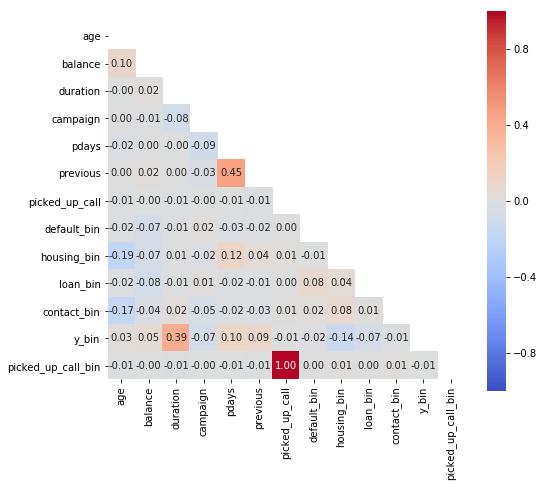

In [0]:
plt.figure(figsize=(8,7))
sns.heatmap(corr_matrix, cmap='coolwarm', vmax=1, vmin=-1, square=True, annot=True, fmt='.2f')


In [0]:
drop_columns_corr = [c for c in cols_corr_limp if (corr_matrix[c].abs() > 0.9).any()]
drop_columns_corr

['picked_up_call']

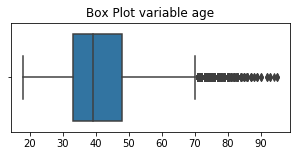

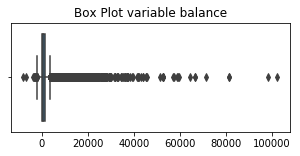

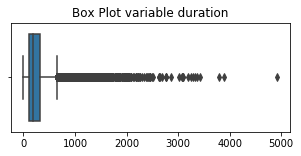

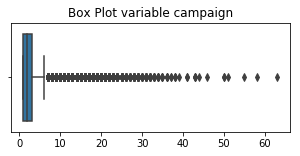

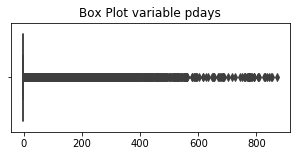

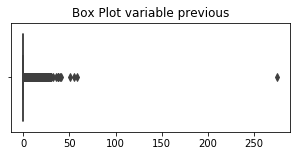

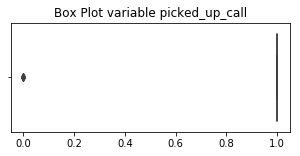

In [0]:
for c in quantitative_vars_limp:
  col_box = df_bank.select(c).toPandas()
  plt.figure(figsize=(5,2))
  plt.title('Box Plot variable ' + c)
  sns.boxplot(col_box, orient='h')
  

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


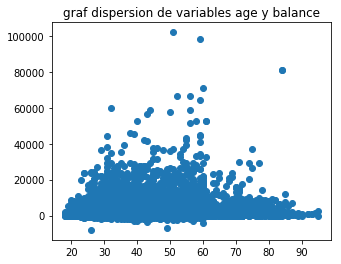

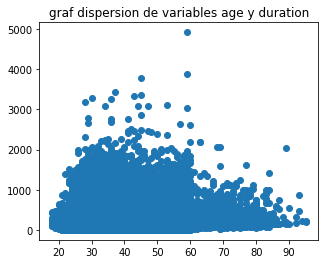

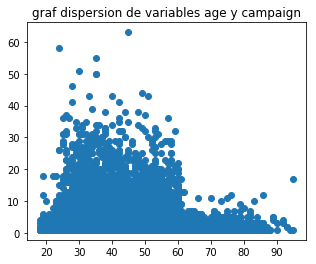

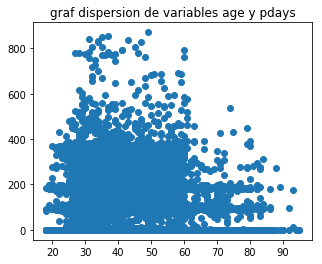

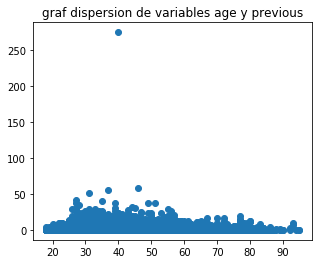

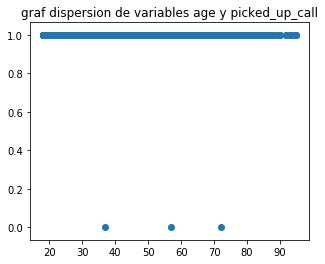

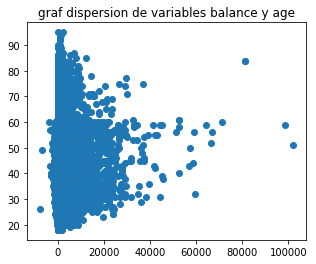

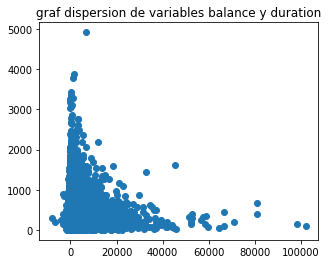

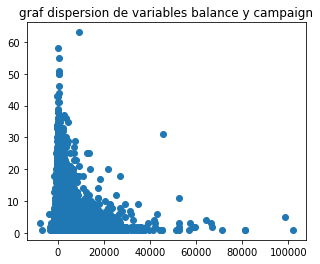

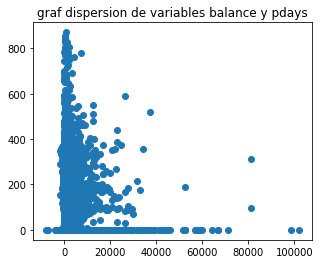

In [0]:
for c in quantitative_vars_limp:
  for d in quantitative_vars_limp:
    if c!=d:
      col_disp1 = df_bank.select(c).toPandas()
      col_disp2 = df_bank.select(d).toPandas()
      plt.figure(figsize=(5,4))
      plt.title('graf dispersion de variables ' + c + ' y ' + d )
      plt.scatter(col_disp1, col_disp2)


In [0]:
def remove_tukey_outliers(df, col):
  q1, q3 = df.approxQuantile(col, [0.25, 0.75], 0.01)
  IQR = q3 - q1
  min_thresh = q1 - 3 * IQR
  max_thresh = q3 + 3 * IQR
   
  df_no_outliers = df.filter(F.col(col).between(min_thresh, max_thresh))
   
  return df_no_outliers

In [0]:
nrows= shape(df_bank)[0]
ncols= shape(df_bank)[1]
print('El dataframe tiene {} filas y {} columnas'.format(nrows,ncols))

El dataframe tiene 45211 filas y 18 columnas


In [0]:
col_outlier = ['age','duration','campaign','previous']
for column in col_outlier:
  df_bank = remove_tukey_outliers(df_bank,column)
 

In [0]:
nrows= shape(df_bank)[0]
ncols= shape(df_bank)[1]
print('El dataframe tiene {} filas y {} columnas'.format(nrows,ncols))

El dataframe tiene 34544 filas y 18 columnas


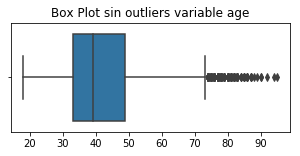

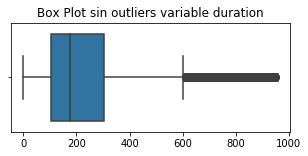

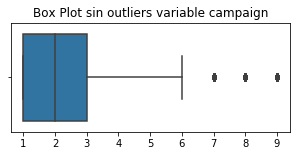

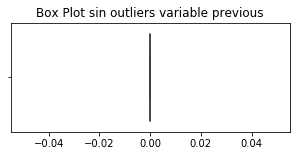

In [0]:
for c in col_outlier:
  col_box = df_bank.select(c).toPandas()
  plt.figure(figsize=(5,2))
  plt.title('Box Plot sin outliers variable ' + c)
  sns.boxplot(col_box, orient='h')
  